# PROJET 1
# TACHE 2: The Stanford Sentiment Treebank 


### IMPORTS and SETUP

In [1]:
import os
import csv
from timeit import default_timer as timer
from collections import Counter
import itertools

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import statistics
import nltk

import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras import activations
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [2]:
!pip install -q -U keras-tuner

In [3]:
import keras_tuner as kt

In [4]:
def to_min(t):
    return round((timer()-t) / 60, 2)
def to_sec(t):
    return timer()-t

In [5]:
nltk.download('treebank')

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Package treebank is already up-to-date!


True

### LOAD DATA

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
#
# DATA files
#
data_path = '/content/drive/MyDrive/data'
dev_file = data_path + '/dev.tsv'
train_file =  data_path + '/train.tsv'
test_file =  data_path + '/test.tsv'

Extract only the phrases with a '*' from the dev.tsv file

In [8]:
dev_dataset = []
dev_targets = []
dev_sentences_size_list = []

with open(dev_file) as file:
    rd = csv.reader(file, delimiter="\t")
    next(rd) #skips first line where the name of the colons is
    for row in rd:
        dev_dataset.append(row[0])
        dev_targets.append(int(row[1])) #target 0 or 1 to int
        
        # store each sentence size in an array 
        dev_sentences_size_list.append(len(nltk.wordpunct_tokenize(row[0]))) # With punctuation

In [9]:
print(dev_dataset[:3])
print(dev_targets[:3])

["it 's a charming and often affecting journey . ", 'unflinchingly bleak and desperate ', 'allows us to hope that nolan is poised to embark a major career as a commercial yet inventive filmmaker . ']
[1, 0, 1]


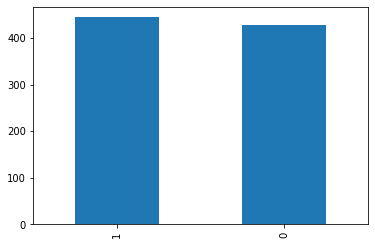

In [10]:
pd.Series(dev_targets).value_counts().plot(kind="bar")

In [11]:
train_dataset = []
train_targets = []

test_dataset = []
test_targets = []

with open(train_file) as file:
    rd = csv.reader(file, delimiter="\t")
    next(rd) #skips first line where the name of the colons is
    for row in itertools.islice(rd, 0, 872):
        test_dataset.append(row[0])
        test_targets.append(int(row[1])) #target 0 or 1 to int
    for row in itertools.islice(rd, 873, 60000):
        train_dataset.append(row[0])
        train_targets.append(int(row[1])) #target 0 or 1 to int

### SPLIT DATA

In [12]:
# convert to tf.data.Dataset
train_ds = tf.data.Dataset.from_tensor_slices((train_dataset, train_targets))
test_ds = tf.data.Dataset.from_tensor_slices((test_dataset, test_targets))
val_ds = tf.data.Dataset.from_tensor_slices((dev_dataset, dev_targets))

In [13]:
for inputs, targets in train_ds.take(5):
    print ('Phrase: {}, Sentiment Target: {}'.format(inputs, targets))
    print()

Phrase: b'this does not really make the case the kissinger should be tried as a war criminal . ', Sentiment Target: 0

Phrase: b"benefit enormously from the cockettes ' camera craziness ", Sentiment Target: 1

Phrase: b'in its sparkling beauty ', Sentiment Target: 1

Phrase: b"`` brown sugar '' admirably aspires to be more than another `` best man '' clone by weaving a theme throughout this funny film . ", Sentiment Target: 1

Phrase: b'features one of the most affecting depictions of a love affair ever committed to film . ', Sentiment Target: 1



In [14]:
print('Train Dataset Size:', train_ds.cardinality().numpy())
print('Validation Dataset Size:', val_ds.cardinality().numpy())
print('Test Dataset Size:', test_ds.cardinality().numpy())

Train Dataset Size: 59127
Validation Dataset Size: 872
Test Dataset Size: 872


In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32

train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = val_ds.batch(BATCH_SIZE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = test_ds.batch(BATCH_SIZE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

for inputs, targets in train_ds.take(1):
    print('Desciptions: ', inputs.numpy()[:3])
    print('Sentiment Target: ', targets.numpy()[:3])
    print()

Desciptions:  [b'this does not really make the case the kissinger should be tried as a war criminal . '
 b"benefit enormously from the cockettes ' camera craziness "
 b'in its sparkling beauty ']
Sentiment Target:  [0 1 1]



### CREATE ENCODER and BUILD VOCAB

In [16]:
vocab_size = 40000
sequence_length = 128

encoder = TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length
)
encoder.adapt(train_ds.map(lambda inputs, targets: inputs))

vocab = encoder.get_vocabulary()
vocab[:20]

['',
 '[UNK]',
 'the',
 'a',
 'and',
 'of',
 'to',
 's',
 'is',
 'that',
 'in',
 'it',
 'as',
 'with',
 'an',
 'film',
 'its',
 'for',
 'movie',
 'this']

### PART 1: BASELINE MODEL

we use the baseline classifier from tensorsflow basic text classifier found here: https://www.tensorflow.org/tutorials/keras/text_classification

Before we create the model we're going to vectorize our dataset first

In [47]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return encoder(text), label

In [48]:
baseline_train_ds = train_ds.map(vectorize_text)
baseline_val_ds = val_ds.map(vectorize_text)
baseline_test_ds = test_ds.map(vectorize_text)

In [49]:
embedding_dim = 16

baseline_model = tf.keras.Sequential([
  layers.Embedding(vocab_size + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1, activation='sigmoid')])

baseline_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 16)          640016    
                                                                 
 dropout_4 (Dropout)         (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 640,033
Trainable params: 640,033
Non-trainable params: 0
__________________________________________________

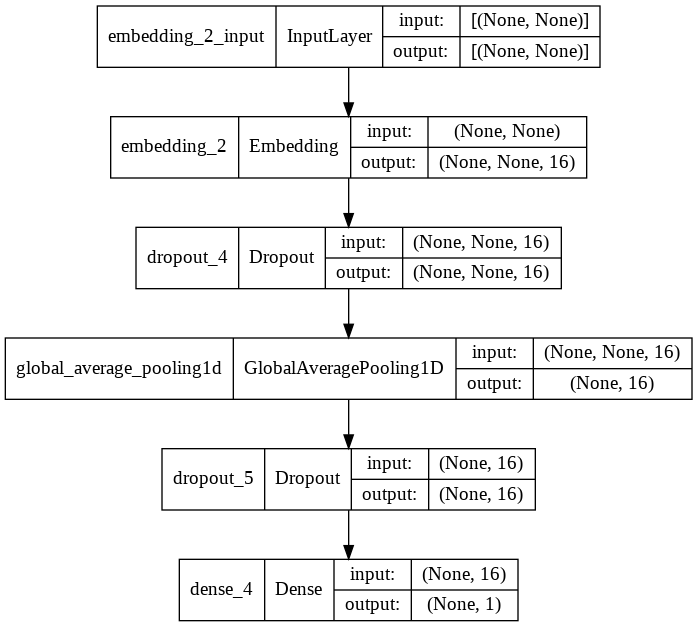

In [50]:
dot_img_file = data_path + '/model_baseline.png'
tf.keras.utils.plot_model(baseline_model, to_file=dot_img_file, show_shapes=True)

In [51]:
baseline_model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.5))

In [53]:
baseline_history = baseline_model.fit(
    baseline_train_ds,
    validation_data=baseline_val_ds,
    epochs=10)

Epoch 1/10
1848/1848 [==============================] - 17s 9ms/step - loss: 0.6647 - binary_accuracy: 0.5844 - val_loss: 0.6226 - val_binary_accuracy: 0.6984


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Epoch 2/10
1848/1848 [==============================] - 16s 9ms/step - loss: 0.5831 - binary_accuracy: 0.7190 - val_loss: 0.5202 - val_binary_accuracy: 0.7592
Epoch 3/10
1848/1848 [==============================] - 17s 9ms/step - loss: 0.4883 - binary_accuracy: 0.8015 - val_loss: 0.4597 - val_binary_accuracy: 0.7821
Epoch 4/10
1848/1848 [==============================] - 17s 9ms/step - loss: 0.4136 - binary_accuracy: 0.8465 - val_loss: 0.4350 - val_binary_accuracy: 0.8085
Epoch 5/10
1848/1848 [==============================] - 17s 9ms/step - loss: 0.3610 - binary_accuracy: 0.8689 - val_loss: 0.4312 - val_binary_accuracy: 0.8131
Epoch 6/10
1848/1848 [==============================] - 16s 9ms/step - loss: 0.3220 - binary_accuracy: 0.8841 - val_loss: 0.4371 - val_binary_accuracy: 0.8142
Epoch 7/10
1848/1848 [==============================] - 17s 9ms/step - loss: 0.2931 - binary_accuracy: 0.8938 - val_loss: 0.4496 - val_binary_accuracy: 0.8085
Epoch 8/10
1848/1848 [========================

In [54]:
loss, accuracy = baseline_model.evaluate(baseline_test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

28/28 [==============================] - 0s 2ms/step - loss: 0.2904 - binary_accuracy: 0.8956
Loss:  0.29035401344299316
Accuracy:  0.8956422209739685


In [55]:
history_dict = baseline_history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

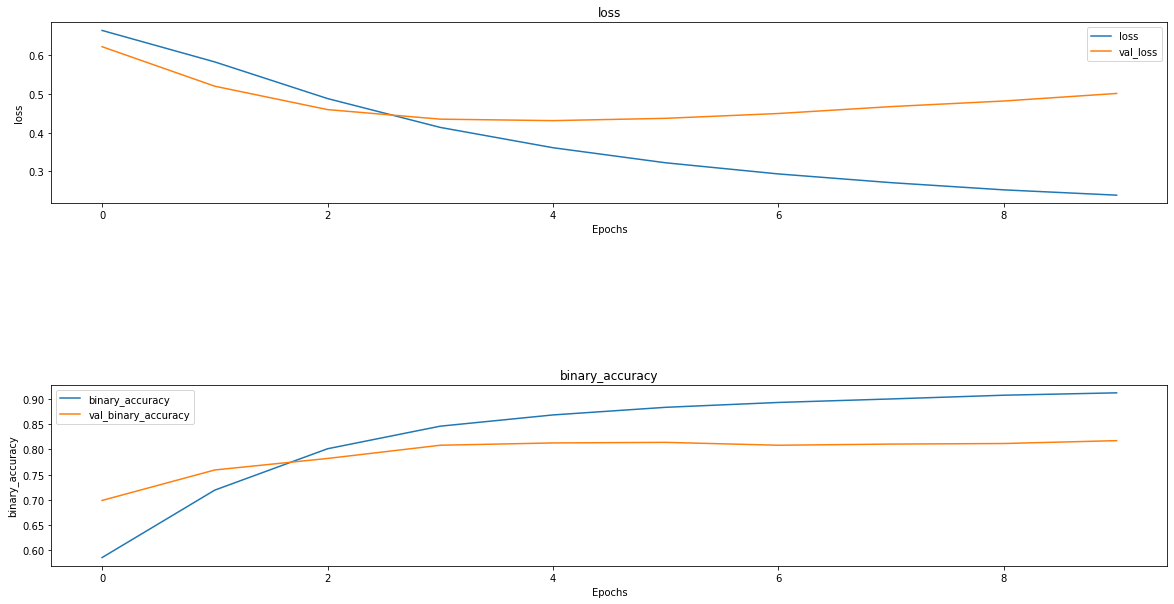

In [58]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.title(metric)


fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(hspace=1)

plt.subplot(2, 1, 1)
plot_graphs(baseline_history, 'loss')

plt.subplot(2, 1, 2)
plot_graphs(baseline_history, 'binary_accuracy')
fig.savefig(data_path +'/train_baseline.png', dpi=fig.dpi)


In [ ]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was extremely terrible..."
]
examples = encoder(examples)
baseline_model.predict(examples)

array([[0.4885106 ],
       [0.48519042],
       [0.4807818 ]], dtype=float32)

### PART 2: COMPLEX MODEL

In [23]:
def build_model(hp):
    # Define model layers:
    #Input Layer
    input_layer = layers.Input(shape=(), dtype=tf.string, name='text')
    
    #Encoder Layer
    encoded = encoder(input_layer)
    
    #Embedding Layer
    embed_layer = layers.Embedding(
        input_dim=len(vocab),
        output_dim=64,
        # change to true to Use masking to handle the variable sequence lengths
        mask_zero=True)
    embedded = embed_layer(encoded)
    
    #RNN Layer with a double bidirectional LSTM layers
    
    #UPDATE: we use Keras Tuner to find the best number of units for the stacked lSTMs
    #hp_units = hp.Int('units',min_value=32, max_value=128, step=32)
    hp_units = hp.Fixed('units', 32)
    
    
    #we need return_sequences=True so that its output tensor has ndim=3 (i.e. batch size, timesteps, hidden state).
    lstm_layer_1 = layers.Bidirectional(layers.LSTM(hp_units, return_sequences=True, dropout=0.5))
    lstm_layer_2 = layers.Bidirectional(layers.LSTM(hp_units, dropout=0.5))
    y_output = lstm_layer_1(embedded)
    y_output = lstm_layer_2(y_output)
    
    # # first fc layer
    fc_layer_1 = layers.Dense(128, activation='relu')
    y_output = fc_layer_1(y_output)
    dropout_1 = layers.Dropout(0.2)
    y_output = dropout_1(y_output)
    
    # # Second fc layer
    fc_layer_2 = layers.Dense(64, activation='relu')
    #fc_layer_2 = layers.Dense(32, activation='relu')
    y_output = fc_layer_2(y_output)
    dropout_2 = layers.Dropout(0.3)
    y_output = dropout_2(y_output)
    
    # Last fc layer 
    # We choose the activation method as a sigmoid to get an output ranging between [0, 1]
    fc_layer_3 = layers.Dense(1, activation='sigmoid', name='target')
    y_output = fc_layer_3(y_output)
    
    # Define the model with the input layer and an output
    model = tf.keras.Model(inputs=input_layer, outputs=y_output, name='sst_predictor')
    
    # Compile The model
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    #hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    hp_learning_rate = hp.Fixed('learning_rate', 1e-4)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
              loss='binary_crossentropy',
              metrics=tf.metrics.BinaryAccuracy())
    return model

In [24]:
keras_tuning_dir = data_path+'/keras_tuning'

tuner = kt.BayesianOptimization(
    build_model,
    objective=kt.Objective("val_loss", direction="min"),
    max_trials=1,
    #max_trials=1,
    executions_per_trial=1,
    directory=keras_tuning_dir,
    project_name='sst_predictor',
    overwrite=True)

In [25]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

tuner.search(train_ds,
    epochs=5,
    validation_data=val_ds,
    #callbacks=[stop_early]
    )

Trial 1 Complete [00h 52m 17s]
val_loss: 0.42401522397994995

Best val_loss So Far: 0.42401522397994995
Total elapsed time: 00h 52m 17s
INFO:tensorflow:Oracle triggered exit


In [22]:
 # Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units for both stacked LSTMs is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units for both stacked LSTMs is 16 and the optimal learning rate for the optimizer
is 0.01.



In [88]:
model = tuner.hypermodel.build(best_hps)
 
model.summary()

Model: "sst_predictor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None,)]                 0         
                                                                 
 text_vectorization (TextVec  (None, 128)              0         
 torization)                                                     
                                                                 
 embedding_4 (Embedding)     (None, 128, 64)           936000    
                                                                 
 bidirectional_8 (Bidirectio  (None, 128, 32)          10368     
 nal)                                                            
                                                                 
 bidirectional_9 (Bidirectio  (None, 32)               6272      
 nal)                                                            
                                                     

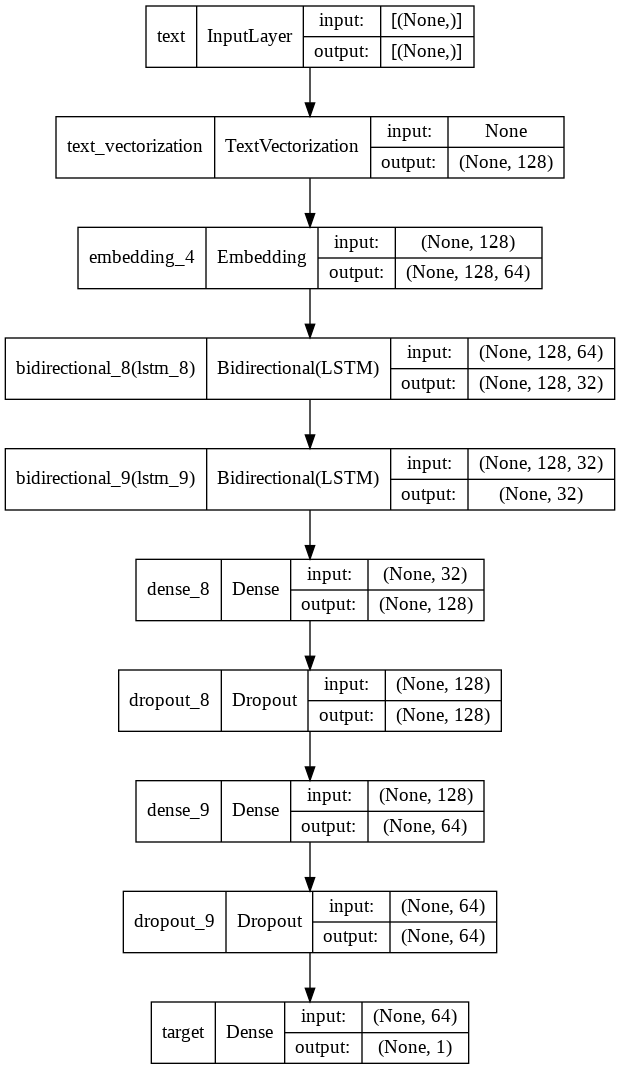

In [89]:
dot_img_file = data_path + '/model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [94]:
history = model.fit(
    train_ds,
    epochs=5,
    validation_data=val_ds,
    #callbacks=[stop_early]
    )

Epoch 1/5
  28/1848 [..............................] - ETA: 9:37 - loss: 0.4110 - binary_accuracy: 0.8192

KeyboardInterrupt: ignored

In [34]:
model.metrics_names

['loss', 'binary_accuracy']

In [35]:
loss, accuracy= model.evaluate(test_ds)

print("Test Loss: ", loss)
print("Test Accuracy: ", accuracy)

28/28 [==============================] - 3s 96ms/step - loss: 0.2633 - binary_accuracy: 0.9266
Test Loss:  0.2632988393306732
Test Accuracy:  0.9266055226325989


In [36]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

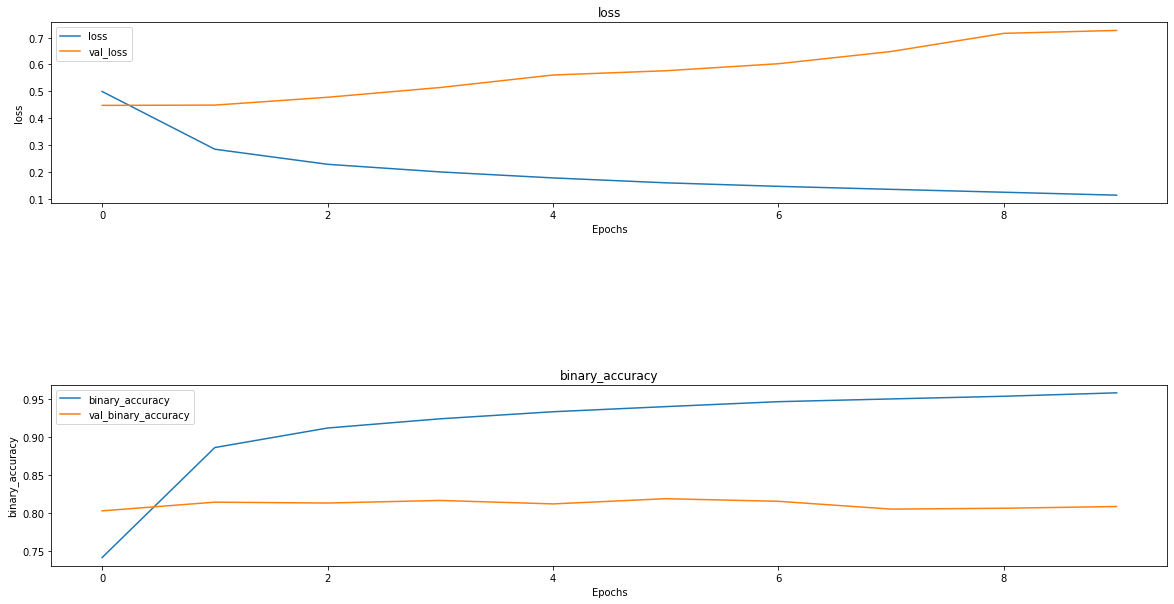

In [37]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.title(metric)

fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(hspace=1)

plt.subplot(2, 1, 1)
plot_graphs(history, 'loss')

plt.subplot(2, 1, 2)
plot_graphs(history, 'binary_accuracy')

In [38]:
# Save the entire model as a SavedModel.
model.save(data_path + '/model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/data/model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/data/model/assets


In [39]:
examples = [
  "The movie was really great!",
  "The movie was okay.",
  "The movie was extremely terrible..."
]

model.predict(examples)

array([[0.97702277],
       [0.93915457],
       [0.03980312]], dtype=float32)

In [61]:
for inputs, targets in train_ds.shuffle(755).take(5):
  predictions = model.predict(inputs)
  predictions = np.round(predictions)

  for idx, val in enumerate(targets.numpy()):
    if int(predictions[idx][0]) != int(val):
      print('Phrase: {}, Target: {}, Wrong Prediction: {}'.format(inputs[idx], val, int(predictions[idx][0])))
      print()

Phrase: b'it wears its heart on the sleeve of its gaudy hawaiian shirt . ', Target: 0, Wrong Prediction: 1

Phrase: b'that suck the audience in ', Target: 1, Wrong Prediction: 0

Phrase: b'that the film never feels derivative ', Target: 1, Wrong Prediction: 0

Phrase: b"wo n't feel like it 's wasted yours ", Target: 1, Wrong Prediction: 0

Phrase: b"can not mount a cogent defense of the film as entertainment , or even performance art , although the movie does leave you marveling at these guys ' superhuman capacity to withstand pain . ", Target: 0, Wrong Prediction: 1

Phrase: b'without much success ', Target: 0, Wrong Prediction: 1

Phrase: b'strangely comes off as a kingdom more mild than wild . ', Target: 1, Wrong Prediction: 0



In [64]:
extra_file =  data_path + '/sst-alaeddine_mellouli-charles_colella_fabrice_lamarche.tsv'

In [65]:
extra_dataset = []
extra_targets = []

with open(extra_file) as file:
    rd = csv.reader(file, delimiter="\t")
    next(rd) #skips first line where the name of the colons is
    for row in rd:
        extra_dataset.append(row[0])
        extra_targets.append(int(row[1])) #target 0 or 1 to int

In [66]:
extra_ds = tf.data.Dataset.from_tensor_slices((extra_dataset, extra_targets))

In [67]:
#should be 50
print('Extra Dataset Size:', extra_ds.cardinality().numpy())

Extra Dataset Size: 50


In [68]:
extra_ds = extra_ds.batch(BATCH_SIZE)
extra_ds = extra_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [69]:
for inputs, targets in extra_ds.take(5):
    print ('Phrase: {}, Sentiment Target: {}'.format(inputs, targets))
    print()

Phrase: [b'funny enough , but nothing new' b'far from a groundbreaking film'
 b'horror' b"it looks like a comedy movie , but it's not "
 b'personal and touching ' b'rooting for this movie '
 b"viewers don't have to worry about being subjected to foul and offensive jokes that have overrun modern-day comedies "
 b"tear your eyes it's better than seeing this movie"
 b'bitter and sweet  ' b"it's like rocky on steroids "
 b"might just be the movie you've been waiting for "
 b'many aspire to be like it but none can equal  '
 b"should come with the warning 'for serious movie lovers only' "
 b'uncompromising ' b'this movie has stuck around for long '
 b'go see a better horror movie'
 b'the emotions are raw and will strike a nerve with anyone with a family . '
 b'be smarter than any 25 other film makers still not good'
 b'get a bit weird but overall acceptable '
 b"people complaining when a movie is only 90 minutes these days, it's worth it"
 b'it goes down easily '
 b'every once in a while , a

In [70]:
loss, accuracy= model.evaluate(extra_ds)

print("Extra Loss: ", loss)
print("Extra Accuracy: ", accuracy)

2/2 [==============================] - 0s 83ms/step - loss: 1.7649 - binary_accuracy: 0.4000
Extra Loss:  1.7648518085479736
Extra Accuracy:  0.4000000059604645
